In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

In [11]:
# Load abundance tables
pge_abund_table = pd.read_csv("../../Data/PGE/PGE_abundance_table.csv", index_col=0)
no_pge_abund_table = pd.read_csv(
    "../../Data/NO_PGE/NO_PGE_abundance_table.csv", index_col=0
)

# Set output dir
OUTPUT_DIR = Path("../../Output/EDA")

### Distribution of raw OTU counts

In [21]:
def plot_otu_abundance_distribution(abundance_df, biome, output_dir):
    otu_total_counts = abundance_df.sum(axis=1)

    plt.figure(figsize=(8, 5))
    sns.histplot(otu_total_counts, bins=100, log_scale=(True, True))
    plt.xlabel("Total Reads per OTU (log scale)")
    plt.ylabel("Number of OTUs")
    plt.title(f"Distribution of OTU Abundances in {biome} biome")
    plt.tight_layout()
    plt.savefig(output_dir / f"otu_abundance_distribution_{biome}.png", dpi=300)

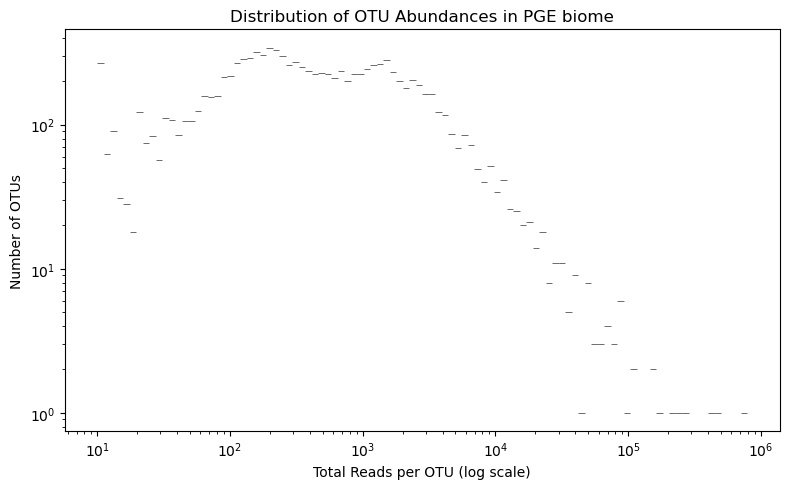

In [ ]:
plot_otu_abundance_distribution(pge_abund_table, "PGE", OUTPUT_DIR)

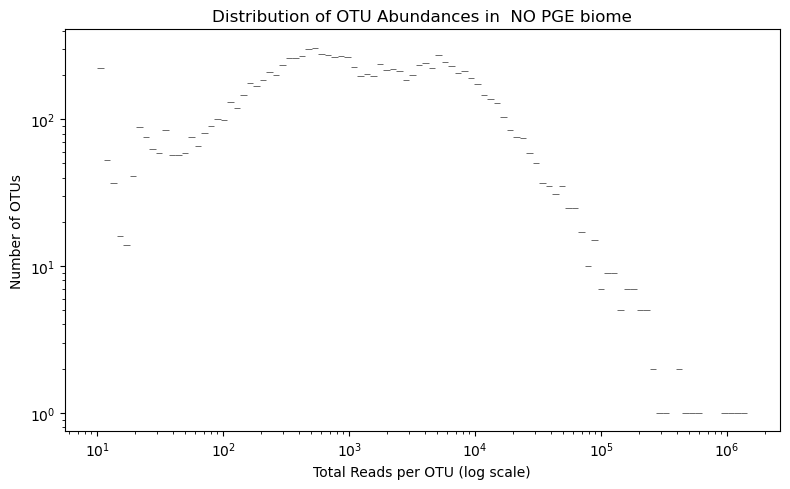

In [23]:
plot_otu_abundance_distribution(no_pge_abund_table, " NO PGE", OUTPUT_DIR)

### OTU Prevalence Across Samples

In [39]:
def plot_otu_prevalence_distribution(abundance_df, biome, output_dir):

    otu_prevalence = (abundance_df > 0).sum(axis=1)
    otu_prevalence_frac = otu_prevalence / abundance_df.shape[1]

    plt.figure(figsize=(8, 5))
    sns.histplot(otu_prevalence_frac, bins=10)
    plt.xlabel("Prevalence (Fraction of Samples)")
    plt.ylabel("Number of OTUs")
    plt.title(f"OTU Prevalence Across Samples in {biome} biome")
    plt.tight_layout()
    plt.savefig(output_dir / f"otu_prevalence_distribution_{biome}.png", dpi=300)

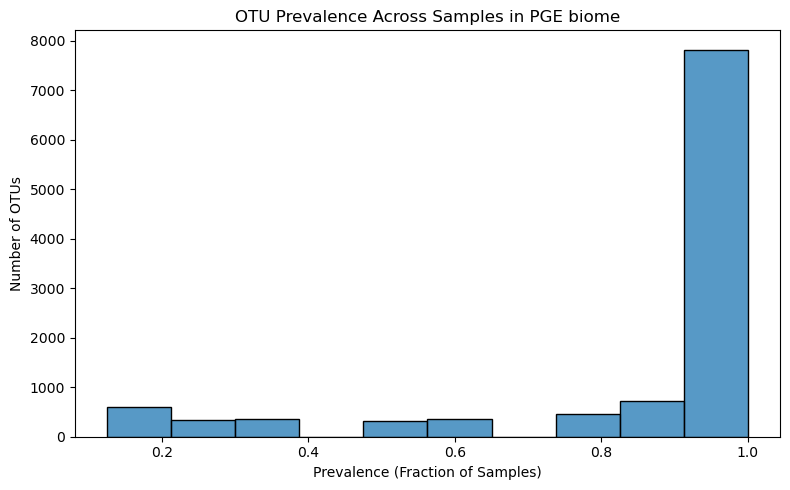

In [40]:
plot_otu_prevalence_distribution(pge_abund_table, "PGE", OUTPUT_DIR)

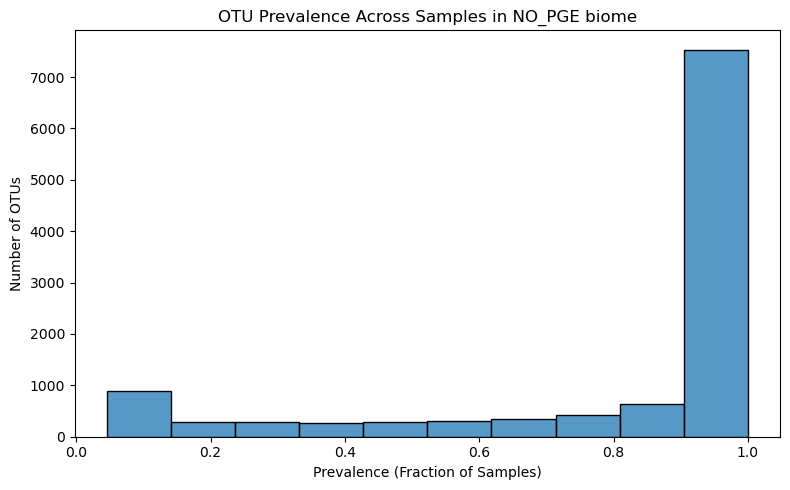

In [41]:
plot_otu_prevalence_distribution(no_pge_abund_table, "NO_PGE", OUTPUT_DIR)

### Box plot of OTUs across samples

In [43]:
def plot_samplewise_otu_distribution_boxplot(abundance_df, biome, output_dir):

    # Melt the abundance table: OTU x Sample → long-form with columns [OTU, Sample, Reads]
    melted_df = abundance_df.reset_index().melt(
        id_vars="OTU", var_name="Sample", value_name="Reads"
    )

    # Keep only OTUs with non-zero reads for better plotting
    melted_df = melted_df[melted_df["Reads"] > 0]

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=melted_df,
        x="Sample",
        y="Reads",
        showfliers=False
    )
    plt.yscale("log")
    plt.xticks(rotation=90)
    plt.ylabel("Read Count per OTU (log scale)")
    plt.xlabel("Sample")
    plt.title(f"Distribution of OTU Abundances per Sample in {biome} biome")
    plt.tight_layout()
    plt.savefig(output_dir / f"otu_counts_boxplot_per_sample_{biome}.png", dpi=300)

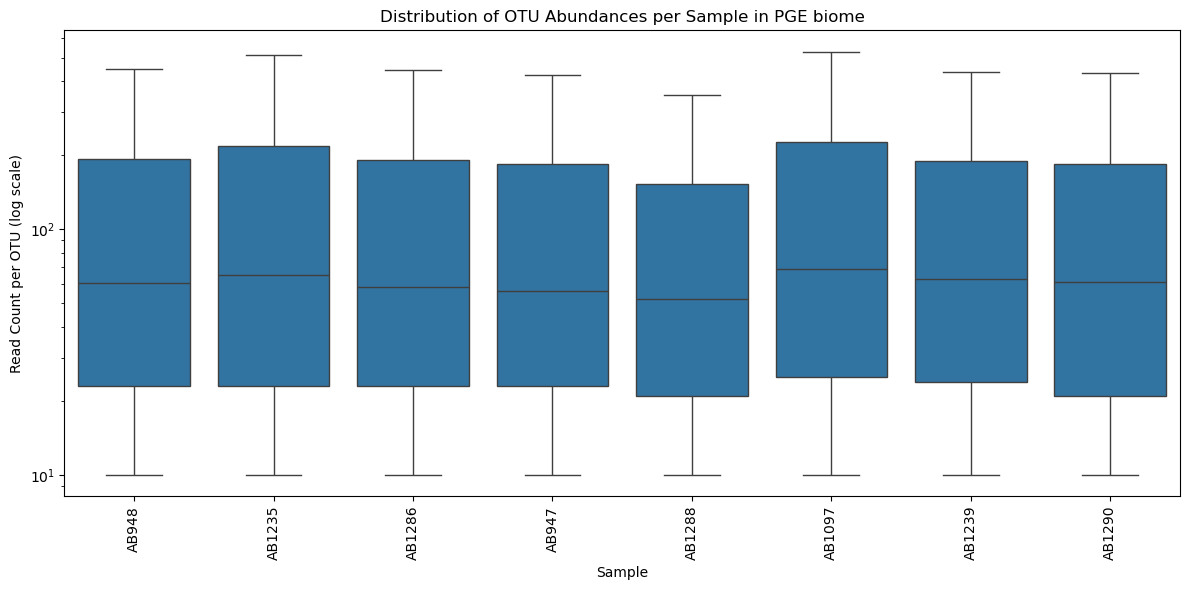

In [44]:
plot_samplewise_otu_distribution_boxplot(pge_abund_table, "PGE", OUTPUT_DIR)

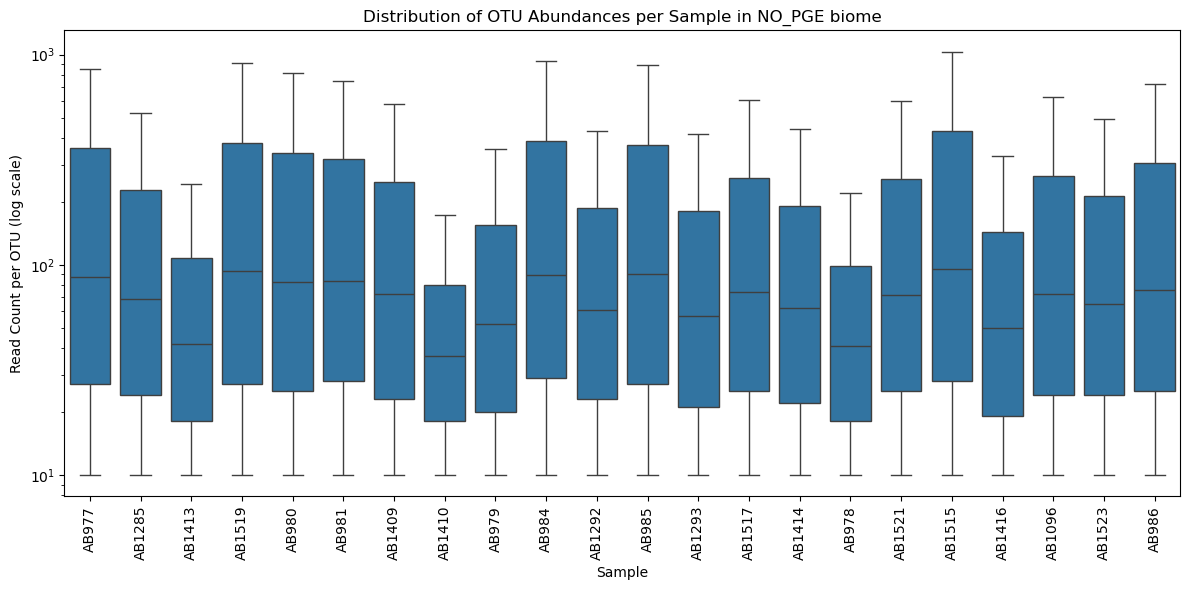

In [45]:
plot_samplewise_otu_distribution_boxplot(no_pge_abund_table, "NO_PGE", OUTPUT_DIR)

### OTU filtering analysis

In [ ]:
def summarize_otu_filtering(abundance_df, rel_freq_thresholds, prevalence_thresholds):
    """
    Test combinations of relative frequency and prevalence thresholds.

    Returns a summary DataFrame with the number of OTUs remaining for each combination.
    """
    results = []

    # Compute relative abundance matrix (OTUs x Samples)
    rel_abundance = abundance_df.div(abundance_df.sum(axis=0), axis=1)

    for rel_thresh in rel_freq_thresholds:
        for prev_thresh in prevalence_thresholds:
            # Step 1: Boolean matrix of OTUs that pass relFreq threshold per sample
            presence_matrix = rel_abundance >= rel_thresh

            # Step 2: Compute prevalence
            prevalence = presence_matrix.sum(axis=1) / presence_matrix.shape[1]

            # Step 3: Filter OTUs
            kept_otus = prevalence[prevalence >= prev_thresh].index
            n_otus = len(kept_otus)

            results.append(
                {
                    "min_rel_freq": rel_thresh,
                    "min_prevalence": prev_thresh,
                    "OTUs_retained": n_otus,
                }
            )

    return pd.DataFrame(results)

In [51]:
# Define the thresholds you want to test
rel_freqs = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005]
prevalences = [0.1, 0.25, 0.5, 0.75]

# Run the filtering summary
pge_filt_summ = summarize_otu_filtering(pge_abund_table, rel_freqs, prevalences)
pge_filt_summ

,min_rel_freq,min_prevalence,OTUs_retained
0,0.00001,0.10,8398
1,0.00001,0.25,7682
2,0.00001,0.50,6973
3,0.00001,0.75,6348
4,0.00005,0.10,4188
5,0.00005,0.25,3783
6,0.00005,0.50,3372
7,0.00005,0.75,3055
8,0.00010,0.10,2648
9,0.00010,0.25,2241


In [52]:
no_pge_filt_summ = summarize_otu_filtering(no_pge_abund_table, rel_freqs, prevalences)
no_pge_filt_summ

,min_rel_freq,min_prevalence,OTUs_retained
0,0.00001,0.10,7991
1,0.00001,0.25,7238
2,0.00001,0.50,6529
3,0.00001,0.75,5901
4,0.00005,0.10,4000
5,0.00005,0.25,3704
6,0.00005,0.50,3413
7,0.00005,0.75,3023
8,0.00010,0.10,2580
9,0.00010,0.25,2286
